In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Lorenz63 Nudging algorithm on observations with CGKF

### Set Up

Get a "true" x using Euler Maruyama in order to have a conditionally-gaussian system

In [2]:
def EM(x0, T = 100, timesteps = 100000, c = 10):
    delta_t = T/timesteps
    rho = 28
    beta = 8/3
    sigma = 10
    final = np.zeros((timesteps,3))
    final[0] = x0
    for i in range(timesteps-1):
        final[i+1, 0] = final[i,0] + delta_t*(sigma*(final[i,1]-final[i,0]))
        final[i+1, 1] = final[i,1] + delta_t*(final[i,0]*(rho - final[i,2])-final[i,1]) + c*np.random.normal(0,np.sqrt(delta_t))
        final[i+1, 2] = final[i,2] + delta_t*(final[i,0]*final[i,1]-beta*final[i,2])

    return final

In [3]:

rho = 28
beta = 8/3
sigma = 10
T = 100
n = 100000
dt = T/n

sol = EM([0,1,0], timesteps=n, c = 1e-6)
x_true = sol[:,0]
x_vals = x_true.copy() + 2*np.random.randn(len(x_true))

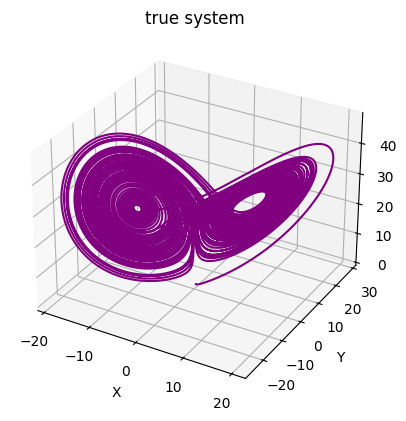

In [4]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(sol[:,0],sol[:,1],sol[:,2], 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.title("true system")
plt.ylabel('Y')
plt.show()

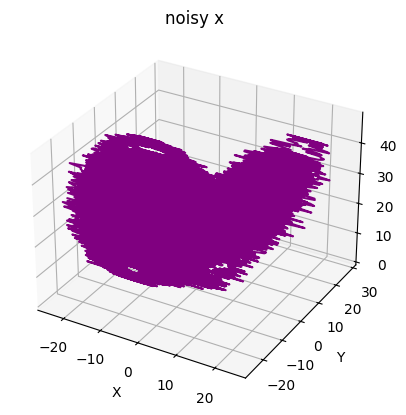

In [5]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x_vals,sol[:,1],sol[:,2], 'purple')
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.title("noisy x")
plt.show()

### Implement Algorithm

In [6]:


def lorenz_kb_nudging(x_obs):
    rho = 28
    beta = 8/3
    sigma = 10
    T = 100
    n = 100000
    dt = T/(n-1)

    Sigma1 = np.array([[1]])

    x_obs = x_obs.copy()
    x_vals = np.zeros_like(x_obs)
    x_vals[0] = x_obs[0]

    Sigma2 = np.diag([.1,0])   

    # random starting point
    u0 = 2*np.random.randn(2)
    u_hat = np.zeros((2,n))
    u_hat[:,0] = u0

    R = np.eye(2)
    Sig_inv = np.linalg.inv(Sigma1@Sigma1.T)
    K = 10
    



    for i in range(1, n): 
        # nudge x toward observations
        y,z = u_hat[:,i-1]
        x = x_vals[i-1]
        F = -sigma*x+sigma*y

        x_vals[i] = x + dt*(F + K*(x_obs[i-1] - x))

        A0 = -sigma*x_vals[i]
        A1 = np.array([[sigma,0]])

        a1 = np.array([[-1,-x_vals[i]],[x_vals[i],-beta]])
        a0 = np.array([rho*x_vals[i],0])

        duI = x_vals[i] - x_vals[i-1]

        innovation = duI - (A0 + (A1 @ u_hat[:,i-1])) * dt
        u_hat[:,i] = u_hat[:,i-1] + dt*(a1@u_hat[:,i-1] + a0) + ((R @ A1.T) @ Sig_inv * innovation).flatten()
        R += (a1@R + R@ a1.T  + Sigma2@Sigma2.T - R@A1.T@Sig_inv@A1@R)*dt

        if np.isnan(R).any():
            print(f"NaN detected at step {i}")
            break
    return x_vals,u_hat






In [7]:
x_nudged,u = lorenz_kb_nudging(x_vals)

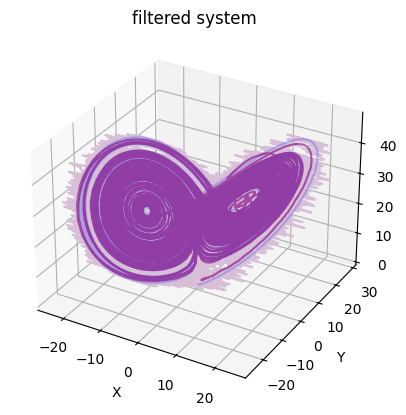

In [16]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x_vals,sol[:,1],sol[:,2], 'thistle')
ax.plot(x_true,sol[:,1],sol[:,2], 'blue', alpha = .2)
ax.plot(x_nudged,u[0],u[1], 'purple', alpha = .6)
ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.title("filtered system")
plt.show()

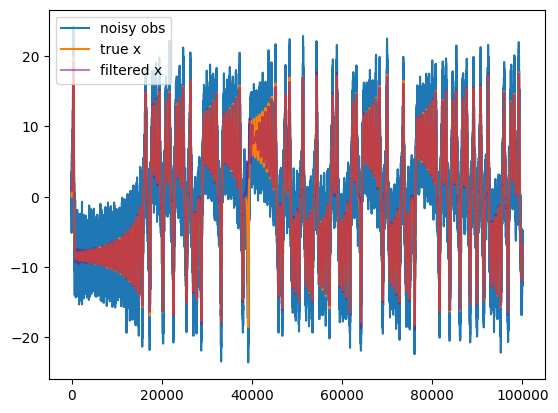

In [9]:
plt.plot(x_vals, label = 'noisy obs')
plt.plot(x_true, label = "true x")
plt.plot(x_nudged, label = 'filtered x', alpha = .5, color = 'purple')
plt.legend()
plt.show()

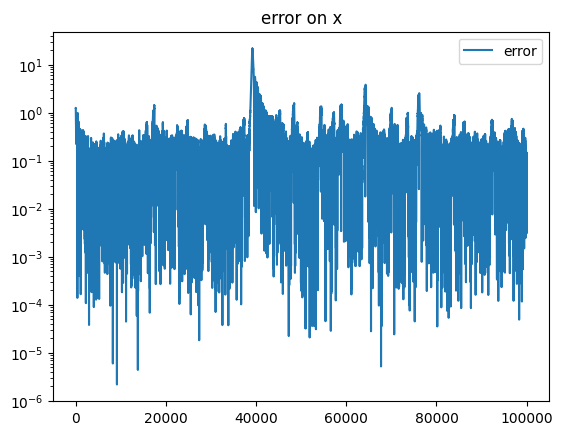

In [10]:
plt.semilogy(np.abs(x_true-x_nudged), label = "error")
plt.legend()
plt.title('error on x')
plt.show()

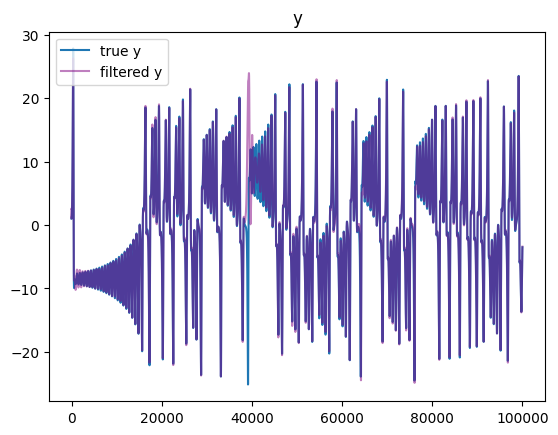

In [11]:
plt.plot(sol[:,1], label = "true y")
plt.plot(u[0], label = 'filtered y', alpha = .5, color = 'purple')
plt.title('y')
plt.legend()
plt.show()

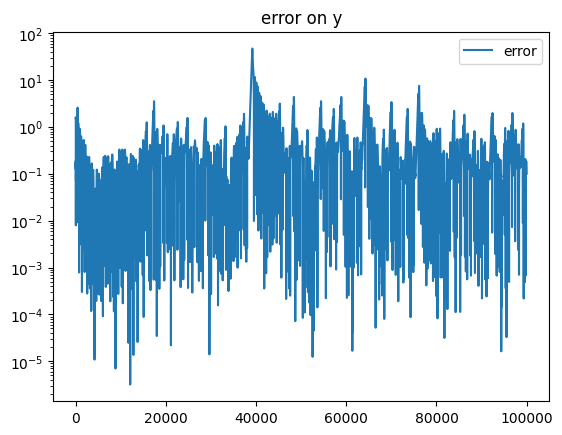

In [12]:
plt.semilogy(np.abs(sol[:,1]-u[0]), label = "error")
plt.legend()
plt.title('error on y')
plt.show()

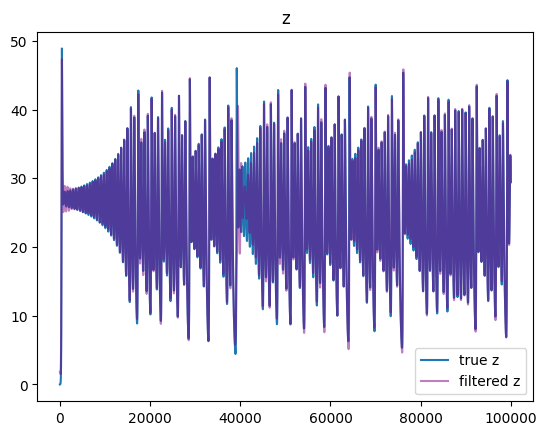

In [13]:
plt.plot(sol[:,2], label = "true z")
plt.plot(u[1], label = 'filtered z', alpha = .5, color = 'purple')
plt.title('z')
plt.legend()
plt.show()

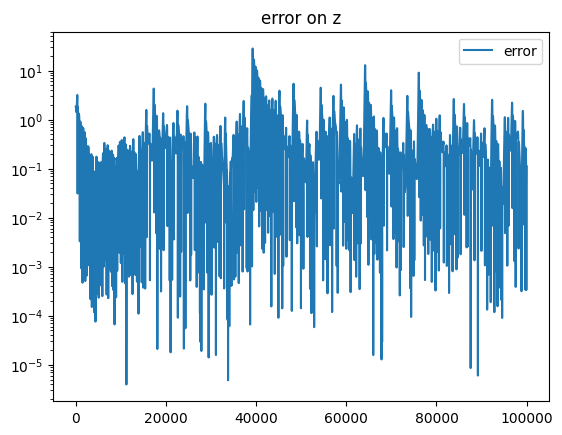

In [14]:
plt.semilogy(np.abs(sol[:,2]-u[1]), label = "error")
plt.legend()
plt.title('error on z')
plt.show()